### Import packages and data

In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [17]:
df = pd.read_csv('../data/Train_call.txt', sep='\t', header=0, )
label = pd.read_csv('../data/Train_clinical.txt', sep='\t', index_col=0)
df

,Chromosome,Start,End,Nclone,Array.129,Array.34,Array.67,Array.24,Array.22,Array.36,...,Array.64,Array.89,Array.30,Array.35,Array.93,Array.10,Array.123,Array.100,Array.134,Array.130
0,1,2927,43870,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
1,1,85022,216735,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
2,1,370546,372295,4,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,-1,0
3,1,471671,786483,5,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,-1,0
4,1,792533,907406,13,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,23,153062077,153452633,57,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2830,23,153466463,153491568,4,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1
2831,23,153504394,153933426,55,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1
2832,23,153938998,153989329,5,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1


### Data visualization

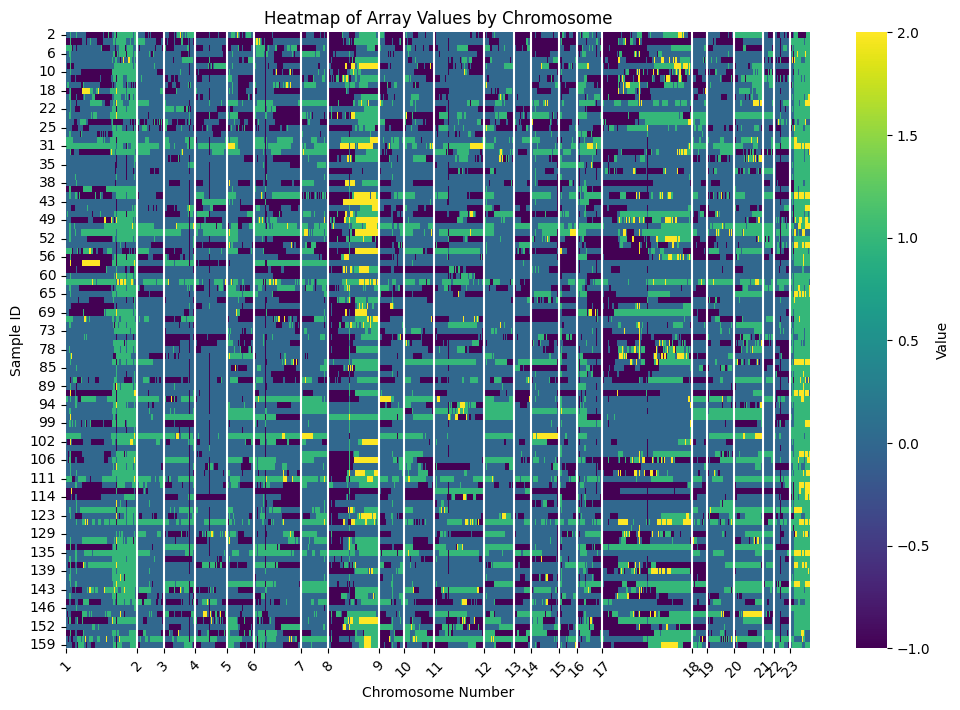

In [13]:
array_data = df.filter(regex='^Array\.\d+$')
# Extracting chromosome and position data
chromosome_position = df[['Chromosome', 'Start']].sort_values(by=['Chromosome', 'Start'])
# Mapping columns to simple ID numbers
array_data.columns = [int(col.split('.')[1]) for col in array_data.columns]

# Sort the columns by sample ID
array_data = array_data.reindex(sorted(array_data.columns), axis=1)

# Assuming 'df' and 'array_data' have already been defined and processed as before
chromosome_labels = df['Chromosome'].unique()  # Unique chromosome labels

# Creating the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(array_data.T, cmap='viridis', cbar_kws={'label': 'Value'})

# Modify x-tick labels to show chromosome numbers only once per chromosome
# Create a new list for labels with positions
chromosome_positions = []
prev_chrom = None
for i, chrom in enumerate(df['Chromosome']):
    if chrom != prev_chrom:
        chromosome_positions.append(i)
        prev_chrom = chrom

# Set x-tick labels
ax.set_xticks([pos for pos in chromosome_positions])
ax.set_xticklabels(chromosome_labels)
plt.xticks(rotation=45)  # Rotate labels for better visibility

# Adding vertical lines after each chromosome
for pos in chromosome_positions[1:]:  # Skip the first position
    plt.axvline(x=pos, color='white')

plt.title('Heatmap of Array Values by Chromosome')
plt.xlabel('Chromosome Number')
plt.ylabel('Sample ID')
plt.show()


Text(0.5, 1.0, 'Correlation matrix of raw data')

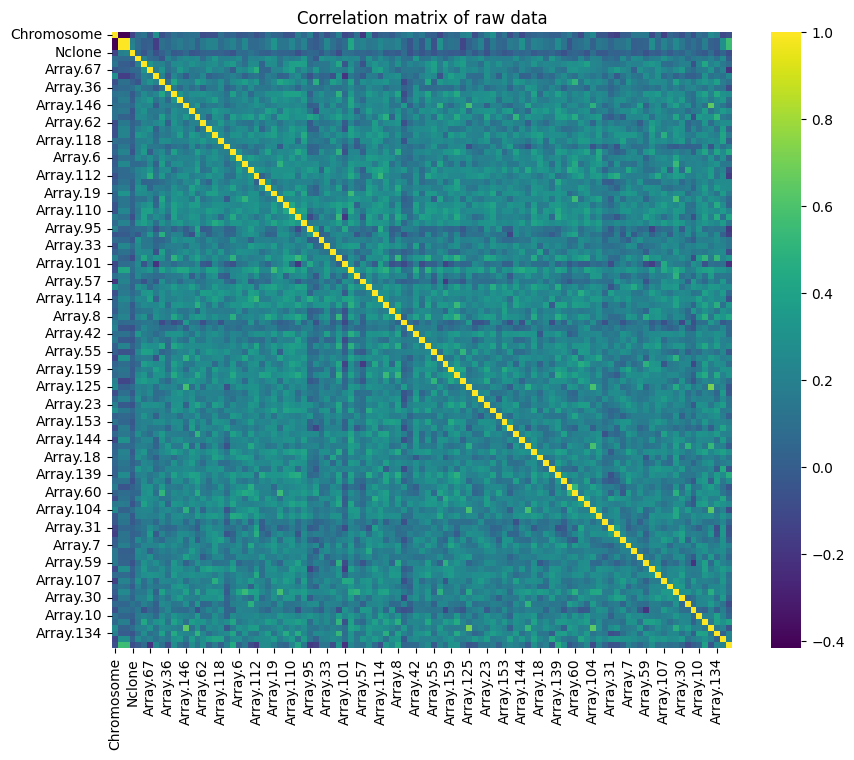

In [14]:
# correlation matrix for each gene
corr_matrix = df.iloc[4:].corr(method='pearson') 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='viridis')
plt.title('Correlation matrix of raw data')

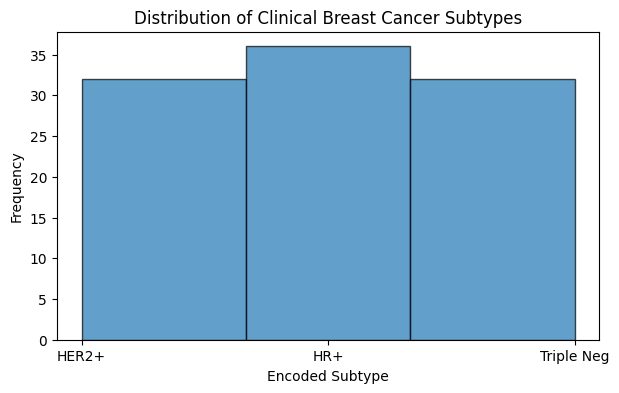

In [73]:
categories = ["HER2+", "HR+", "Triple Neg"]

# Histogram of the labels
plt.figure(figsize=(7, 4))  
plt.hist(y, bins=len(set(y)), alpha=0.7, edgecolor='black')  # Creates the histogram
plt.title('Distribution of Clinical Breast Cancer Subtypes')  # Adds a title
plt.xlabel('Encoded Subtype')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.xticks(range(len(categories)), categories)  # Ensures there is a tick for each class
plt.show()  # Displays the plot

In [74]:
df_X = df.drop(['Chromosome', 'Start', 'End', "Nclone"])
X = np.array(df_X, dtype=np.float64)
le = LabelEncoder()

# Fit label encoder and return encoded labels
label['subgroup_encoded'] = le.fit_transform(label['Subgroup'])
y = label['subgroup_encoded']

df_y = pd.DataFrame(y)
df_X.to_csv('../data/X.csv', index=True)
df_y.to_csv('../data/y.csv', index=True)


### Linear Feature Selection using L1 Logistic Regression

In [34]:
feature_data = pd.read_csv('../Data/Train_call.txt', delimiter='\t')
feature_data = feature_data.drop(['Chromosome', 'Start', 'End', "Nclone"], axis=1).T
label_data = pd.read_csv('../Data/Train_clinical.txt', delimiter='\t', index_col=0)
label_data

,Subgroup
Sample,
Array.129,HER2+
Array.34,HR+
Array.67,HR+
Array.24,Triple Neg
Array.22,Triple Neg
...,...
Array.10,HER2+
Array.123,HR+
Array.100,HR+


In [35]:
feature_data

,0,1,2,3,4,5,6,7,8,9,...,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833
Array.129,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,0,1,1,1,1,1
Array.34,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.67,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.24,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
Array.22,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array.10,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
Array.123,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.100,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.134,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_data)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, label_data, test_size=0.3, random_state=42)

# Logistic regression with L1 penalty
log_reg = LogisticRegression(penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)

# Model evaluation
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       HER2+       0.82      1.00      0.90         9
         HR+       0.60      0.50      0.55        12
  Triple Neg       0.44      0.44      0.44         9

    accuracy                           0.63        30
   macro avg       0.62      0.65      0.63        30
weighted avg       0.62      0.63      0.62        30



/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
# First Logistic Regression with L1 penalty
logreg1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, multi_class='ovr')
logreg1.fit(X_train, y_train)

# Create a boolean mask for features with non-zero coefficients in any class
features_first_round = np.any(logreg1.coef_ != 0, axis=0)
selected_features_first_round = X.columns[features_first_round].tolist()

# Apply the mask to reduce X to significant features only
X_reduced_train = X_train[:, features_first_round]
X_reduced_test = X_test[:, features_first_round]

# Second Logistic Regression with L1 penalty on the reduced feature set
logreg2 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, multi_class='ovr')
logreg2.fit(X_reduced_train, y_train)

# Identify features with non-zero coefficients in the second round
features_second_round = np.any(logreg2.coef_ != 0, axis=0)
selected_features_second_round = X.columns[features_first_round][features_second_round].tolist()

# Output selected features
print("Selected features in the first round:", selected_features_first_round, 
      "\n length:", len(selected_features_first_round))
print("Selected features in the second round:", selected_features_second_round,
      "\n length:", len(selected_features_second_round))

# Evaluate model performance on the test set with reduced features
y_pred_first = logreg1.predict(X_test)
accuracy_first = accuracy_score(y_test, y_pred_first)
print("Accuracy on the test set (First Model):", accuracy_first)

y_pred_second = logreg2.predict(X_reduced_test)
accuracy_second = accuracy_score(y_test, y_pred_second)
print("Accuracy on the test set (Second Model):", accuracy_second)


Selected features in the first round: [19, 30, 31, 175, 177, 192, 194, 223, 230, 316, 317, 342, 354, 396, 472, 485, 487, 509, 510, 511, 623, 672, 679, 680, 758, 764, 766, 790, 791, 814, 815, 842, 998, 1035, 1055, 1059, 1170, 1243, 1310, 1312, 1395, 1481, 1642, 1655, 1659, 1663, 1678, 1679, 1683, 1788, 1897, 1899, 1902, 1906, 1907, 1962, 2017, 2023, 2024, 2026, 2184, 2188, 2206, 2207, 2209, 2210, 2211, 2213, 2382, 2427, 2457, 2501, 2655, 2656, 2742, 2747, 2750, 2752] 
 length: 78
Selected features in the second round: [30, 31, 175, 177, 192, 194, 223, 230, 316, 317, 342, 354, 396, 472, 485, 487, 509, 511, 623, 672, 679, 758, 764, 766, 791, 814, 815, 842, 998, 1035, 1055, 1059, 1170, 1243, 1310, 1481, 1642, 1655, 1659, 1663, 1678, 1679, 1683, 1788, 1897, 1899, 1902, 1906, 1907, 1962, 2017, 2023, 2024, 2026, 2184, 2188, 2206, 2207, 2210, 2211, 2213, 2382, 2427, 2457, 2501, 2655, 2656, 2742, 2747, 2750, 2752] 
 length: 71
Accuracy on the test set (First Model): 0.6333333333333333
Accuracy 

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- C Parameter: C is the inverse of regularization strength; smaller values specify stronger regularization. You might need to tune this parameter using, for example, cross-validation.  
- Feature Scaling: Logistic regression is also sensitive to the scale of variables, so it is crucial to scale features before applying these techniques.  
- Model Evaluation: The model's performance is evaluated using accuracy, which is a common metric for classification tasks. Depending on the specific characteristics of your problem (e.g., if the classes are imbalanced), you might prefer other metrics such as F1-score or ROC AUC.  

### Non-Linear Feature Selection using Random Forest